## Import dependencies

In [284]:
from calendar import monthrange
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder

rng = np.random.RandomState(0)

## Load training data frame

In [285]:
df_train = pd.read_excel("data/Vehicles_export_prices_scaled_train_eng.xlsx")

In [286]:
df_train.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,...,CUSTOMER_SALE_GROUP_NAME,CUSTOMER_SALE_GROUP2,CUSTOMER_SALE_GROUP2_NAME,SCALED_CURRENT_VALUE,SCALED_INVENTURAL_VALUE,SCALED_REPORT_VALUE,SCALED_VALUATION_PRICE,SCALED_GUIDE_PRICE,SCALED_TOTAL_SALES_PRICE_BASIS,SCALED_TOTAL_SALE_PRICE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,NaN,...,EV privat,EVPR,Endverbraucher private,0.052907,0.000000,0.950043,0.0,0.002975,0.011018,0.011321
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,...,NaN,NaN,NaN,0.061605,0.000000,0.950043,0.0,0.006136,0.026411,0.019844
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,...,EV privat,EVPR,Endverbraucher private,0.063286,0.000000,0.950043,0.0,0.001378,0.022102,0.022053
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,...,Interne Kunden,INT,Interne Kunden,0.042565,0.029537,0.897257,0.0,0.001378,0.000000,0.000572
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,...,NaN,NaN,NaN,0.054914,0.000000,0.950043,0.0,0.004863,0.019715,0.013360


In [287]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99071 entries, 0 to 99070
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(42), object(59)
memory usage: 80.1+ MB


## Data frame preperation

### Manual dtype correction

In [288]:
dtypes = {
    "date": "datetime64[ns]",
    "num": np.float64,
    "str": pd.StringDtype(),
}

columns_of_interest = {
    "RPAKREP_VEHICLE_HKEY": "str",
    "COMPANY": "str",
    "OFFICE": "str",
    "OFFICE_MAIN_BRAND": "str",
    "CHASSIS_NUMBER": "str",
    "MANUFACTURER_SHORT": "str",
    "MANUFACTURER": "str",
    "VEHICLE_GROUP": "str",
    "VEHICLE_TYPE": "str",
    "MODEL_CODE": "str",
    "VARIANT": "str",
    "MILEAGE": "num",
    "OPERATING_HOURS": "num",
    "MILAGE_IN_FIELD": "num",
    "MILAGE_SALES": "num",
    "OPERATING_HOURS_SALES": "num",
    "RIM_KEY": "str",
    "COLOR_CODE": "str",
    "COLOR_CODE_NAME": "str",
    "COLOR": "str",
    "COLOR_TYPE": "str",
    "UPHOLSTERY_CODE": "str",
    "UPHOLSTERY": "str",
    "UPHOLSTERY_CODE_ALT": "str",
    "CERTIFICATE_TYPE": "str",
    "CERTIFICATE_TYPE_DATE": "num",
    "FACTORY_NUMBER": "str",
    "ENGINE_ID": "str",
    "ENGINE_TYPE": "str",
    "ENGINE_ID_ALT": "str",
    "TRANSMISSION": "str",
    "TRANSMISSION_TYPE": "str",
    "TRANSMISSION_ID": "str",
    "TRANSMISSION_SHORT": "str",
    "TRANSMISSION_NAME": "str",
    "RIMS": "str",
    "FRONT_TIRES": "str",
    "FRONT_TIRES_CONDITION": "num",
    "REAR_TIRES": "str",
    "REAR_TIRES_CONDITION": "num",
    "NUMBER_DOORS": "num",
    "NUMBER_SEATS": "num",
    "PERMITTED_TOTAL_WEIGHT": "num",
    "MAX_TRAILOR_LOAD": "num",
    "CURB_WEIGHT": "num",
    "YEAR_CONSTRUCTION": "num",
    "CONSTRUCTION_MONTH": "num",
    "NUMBER_AXLE": "num",
    "NUMBER_ENGINE_CYLINDER": "num",
    "REPAIR_RKZ": "num",
    "OPTICAL_CONDITION": "num",
    "TECHNICAL_CONDITION": "num",
    "ACCIDENT_VEHICLE": "str",
    "COMMISSION_NUMBER": "str",
    "HORSEPOWER": "num",
    "KW": "num",
    "CCM": "num",
    "NUMBER_OWNERS": "num",
    "IS_USED_CAR": "num",
    "LEASING_CONTRACT_DATE": "date",
    "LEASING_START": "date",
    "LEASING_END": "date",
    "LEASING_MILAGE": "num",
    "PAINT_TYPE": "str",
    "FINANCING_TYPE": "str",
    "FINANCING_TYPE_NAME": "str",
    "KAT_VEHICLE": "str",
    "FUEL_TYPE": "str",
    "FUEL_TYPE_NAME": "str",
    "DRIVE_TYPE": "str",
    "DRIVE_TYPE_NAME": "str",
    "VEHICLE_MODEL_ID": "str",
    "VEHICLE_MODEL_ID_NAME": "str",
    "COMMISSION_TYPE": "str",
    "COMMISSION_TYPE_NAME": "str",
    "DEMONSTRATION_STATUS": "str",
    "PURCHASE_DATE": "date",
    "PURCHASE_BOOKING_DATE": "date",
    "PURCHASE_MILAGE": "num",
    "PURCHASE_OPERATION_HOURS": "num",
    "PRICE_LIST": "str",
    "DAY_OF_REGISTRATION": "str",
    "AT_LOCATION_SINCE": "num",
    "LAID_UP_TIME": "num",
    "SOLD_CUSTOMER_ID": "str",
    "SOLD_INVOICE_COSTUMER_ID": "str",
    "MILAGE_SALE": "num",
    "OPERATION_HOURS_SALE": "num",
    "SOLD_INVOICE_COSTUMER_ID2": "str",
    "CUSTOMER_TYPE": "str",
    "CUSTOMER_GROUP": "str",
    "CUSTOMER_GROUP_NAME": "str",
    "CUSTOMER_FEATURE": "str",
    "CUSTOMER_FEATURE_NAME": "str",
    "SALE_CUSTOMER_ID2": "str",
    "CUSTOMER_SALE_GROUP": "str",
    "CUSTOMER_SALE_GROUP_NAME": "str",
    "CUSTOMER_SALE_GROUP2": "str",
    "CUSTOMER_SALE_GROUP2_NAME": "str",
    "SCALED_CURRENT_VALUE": "num",
    "SCALED_INVENTURAL_VALUE": "num",
    "SCALED_REPORT_VALUE": "num",
    "SCALED_VALUATION_PRICE": "num",
    "SCALED_GUIDE_PRICE": "num",
    "SCALED_TOTAL_SALES_PRICE_BASIS": "num",
    "SCALED_TOTAL_SALE_PRICE": "num",
}


def correct_df_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    return df[columns_of_interest.keys()]\
        .astype({k: dtypes[v] for k, v in columns_of_interest.items()})

### Add custom features

In [289]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]


def create_date(year, month=1, day=1):
    if math.isnan(year) or math.isnan(month) or math.isnan(day):
        return pd.NaT
    if year < 1900:
        return pd.NaT
    return datetime.datetime(int(year), int(month), int(day))


def month_idx_to_name(month_idx):
    if math.isnan(month_idx):
        return pd.NA
    return months[int(month_idx - 1)]


def day_idx_to_name(day_idx):
    if math.isnan(day_idx):
        return pd.NA
    return int(day_idx)


def weekday_idx_to_name(weekday_idx):
    if math.isnan(weekday_idx):
        return pd.NA
    return days[int(weekday_idx)]


def add_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df_feat = df.copy()
    
    # Compare OFFICE_MAIN_BRAND and MANUFACTURER_SHORT
    df_feat["COMP__OFFICE_MAIN_BRAND__MANUFACTURER_SHORT"] = \
        (df_feat["OFFICE_MAIN_BRAND"] == df_feat["MANUFACTURER_SHORT"])\
        .astype(dtypes["num"])

    # Construct datetime from YEAR_CONSTRUCTION and CONSTRUCTION_MONTH
    df_feat["CONSTRUCTION_DATE"] = df_feat[["YEAR_CONSTRUCTION", "CONSTRUCTION_MONTH"]]\
        .apply(lambda x: create_date(year=x["YEAR_CONSTRUCTION"], month=x["CONSTRUCTION_MONTH"]), axis=1)\
        .astype(dtypes["date"])

    # Separate year, month, day, weekday for dates
    for col in df_feat.select_dtypes(include=dtypes["date"]).columns:
        df_feat[f"{col}__YEAR"] = df_feat[col].map(lambda date: date.year)\
            .astype(dtypes["num"])

        df_feat[f"{col}__MONTH"] = df_feat[col].map(lambda date: month_idx_to_name(date.month))\
            .astype(dtypes["str"])

        df_feat[f"{col}__DAY"] = df_feat[col].map(lambda date: day_idx_to_name(date.day))\
            .astype(dtypes["str"])
        
        df_feat[f"{col}__WEEKDAY"] = df_feat[col].map(lambda date: weekday_idx_to_name(date.weekday()))\
            .astype(dtypes["str"])
    
    return df_feat

### Split data frame into features and labels

In [290]:
def split_data_frame(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # Features
    X = df.drop("LAID_UP_TIME", axis=1)

    # Labels
    y = df["LAID_UP_TIME"]

    return X, y

### Preperation function

In [291]:
def prepare_data_frame(df: pd.DataFrame, is_training_data: bool) -> tuple[pd.DataFrame, pd.Series]:
    df_prep = df.copy()
    
    # Keep only unique rows
    df_prep = df_prep.drop_duplicates()

    # Drop train samples without label value
    if is_training_data:
        df_prep = df_prep.dropna(subset=["LAID_UP_TIME"])

    # Manual dtype correction
    df_prep = correct_df_dtypes(df_prep)
    
    # Add custom features
    df_prep = add_custom_features(df_prep)
    
    print(df_prep.info())

    return split_data_frame(df_prep)

### Prepare training data

In [292]:
X, y = prepare_data_frame(df_train, is_training_data=True)

<class 'pandas.core.frame.DataFrame'>
Index: 98821 entries, 0 to 99070
Columns: 132 entries, RPAKREP_VEHICLE_HKEY to CONSTRUCTION_DATE__WEEKDAY
dtypes: datetime64[ns](6), float64(46), string(80)
memory usage: 100.3 MB
None


## Split test and train set

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

mean: 88.56825541388383
std: 104.83340619388476


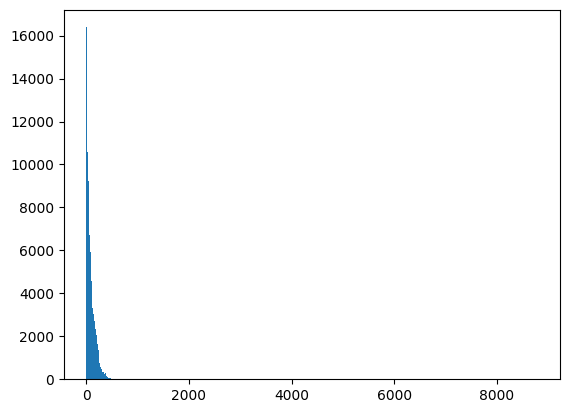

In [294]:
print(f"mean: {np.mean(y_train)}")
print(f"std: {np.std(y_train)}")
plt.hist(y_train, bins=512)
plt.show()

## Preprocessing

In [295]:
def map_date(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda date: date_to_number(date))


def date_to_number(date: np.datetime64) -> np.float64:
    if date is pd.NaT:
        return np.nan
    return date.year + date.month / 12.0 + date.day / (12.0 * monthrange(date.year, date.month)[1])


preprocessor = Pipeline(
    [
        ("per_feature", ColumnTransformer([
            ("date", Pipeline([
                ("converter", FunctionTransformer(map_date)),
                ("imputer", SimpleImputer()),
                ("scaler", RobustScaler()),
            ]), make_column_selector(dtype_include=dtypes["date"])),
            ("num", Pipeline([
                ("imputer", SimpleImputer()),
                ("scaler", RobustScaler()),
            ]), make_column_selector(dtype_include=dtypes["num"])),
            ("str", Pipeline([
                ("imputer", SimpleImputer(missing_values=pd.NA, strategy="constant", keep_empty_features=True, fill_value="N/A")),
                ("encoder", OneHotEncoder(min_frequency=0.01, handle_unknown="infrequent_if_exist", sparse_output=False)),
            ]), make_column_selector(dtype_include=dtypes["str"])),
        ])),
        ("selector", Pipeline([
            ("variance_threshold", VarianceThreshold()),
            ("select_best", SelectPercentile(f_regression, percentile=10)),
        ])),
    ]
)
preprocessor

Pipeline(steps=[('per_feature',
                 ColumnTransformer(transformers=[('date',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function map_date at 0x000001C30C311440>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C34CCCF8F0>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleIm...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.01,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C34BCB0530>)])),
                ('selector',
                 Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                                 ('select_best',
                                  SelectPercentile(score_func=<function f_regression at 0x000001C2C2D83240>))]))])

### Inspect feature correlation

In [296]:
preprocessor.set_output(transform="pandas")
corr_output = preprocessor.fit_transform(X_train, y_train)
preprocessor.set_output(transform="default")
corr_output["LAID_UP_TIME"] = y_train
corr_matrix = corr_output.corr()
print(corr_matrix["LAID_UP_TIME"].sort_values(ascending=False))

LAID_UP_TIME                               1.000000
num__SCALED_INVENTURAL_VALUE               0.304577
str__DRIVE_TYPE_infrequent_sklearn         0.220409
str__DRIVE_TYPE_NAME_infrequent_sklearn    0.220409
str__COMMISSION_TYPE_6                     0.198308
                                             ...   
str__PRICE_LIST_infrequent_sklearn        -0.141287
num__PURCHASE_BOOKING_DATE__YEAR          -0.393241
date__PURCHASE_BOOKING_DATE               -0.421222
num__PURCHASE_DATE__YEAR                  -0.426467
date__PURCHASE_DATE                       -0.460364
Name: LAID_UP_TIME, Length: 72, dtype: float64


## Model selection

### Helper functions

In [300]:
def validate_model(model: BaseEstimator):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("RMSE Std:", rmse_scores.std())

In [301]:
def test_model(model: BaseEstimator):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")

### Linear Regression

In [303]:
linear_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression(n_jobs=-1))
])
validate_model(linear_reg)

RMSE Scores: [71.35889591 69.13356171 97.03423515 67.18372595 94.28981855]
RMSE Mean: 79.80004745220648
RMSE Std: 13.047369220061643


### Random Forest Regressor

In [306]:
rand_forest_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_jobs=-1, random_state=rng))
])
validate_model(rand_forest_reg)

RMSE Scores: [50.35736768 62.82310544 85.33738897 46.58876891 83.11159809]
RMSE Mean: 65.64364581736683
RMSE Std: 16.11016422665923


Next steps:
- GridSearch
- outlier detection
- per feature mapping (to nulls, etc.)